In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janatahack-independence-day-2020-ml-hackathon/sample_submission.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv
/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv


In [3]:
import pandas as pd
df_train=pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/train.csv')
df_test=pd.read_csv('/kaggle/input/janatahack-independence-day-2020-ml-hackathon/test.csv')
df_test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [4]:
df_train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [5]:
import re
import spacy 
import string

def clean_text(text):
    text = text.lower()  

    text = re.sub(r'http\S+|www.\S+', '', text)

    allowed_punct = "-–"
    punct_to_remove = ''.join([p for p in string.punctuation if p not in allowed_punct])
    text = re.sub(rf"[{re.escape(punct_to_remove)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()


    return text
df_train['TITLE'] = df_train['TITLE'].apply(clean_text)
df_train['ABSTRACT'] = df_train['ABSTRACT'].apply(clean_text)

df_test['TITLE'] = df_test['TITLE'].apply(clean_text)       
df_test['ABSTRACT'] = df_test['ABSTRACT'].apply(clean_text) 

In [6]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

def spacy_token_lemma(texts):
    lemmas_list = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100, n_process=1), total=len(texts)):
        lemmas = [token.lemma_ for token in doc if token.is_alpha]
        lemmas_list.append(" ".join(lemmas))
    return lemmas_list

df_train['TITLE'] = spacy_token_lemma(df_train['TITLE'])
df_train['ABSTRACT'] = spacy_token_lemma(df_train['ABSTRACT'])

df_test['TITLE'] = spacy_token_lemma(df_test['TITLE'])
df_test['ABSTRACT'] = spacy_token_lemma(df_test['ABSTRACT'])


100%|██████████| 8989/8989 [01:35<00:00, 94.29it/s] 


In [12]:
df_train['TEXT'] = df_train['TITLE'] + ' ' + df_train['ABSTRACT']
df_test['TEXT'] = df_test['TITLE'] + ' ' + df_test['ABSTRACT']
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000)  
X_train = vectorizer.fit_transform(df_train['TEXT'])
X_test = vectorizer.transform(df_test['TEXT'])


Label counts:
Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64


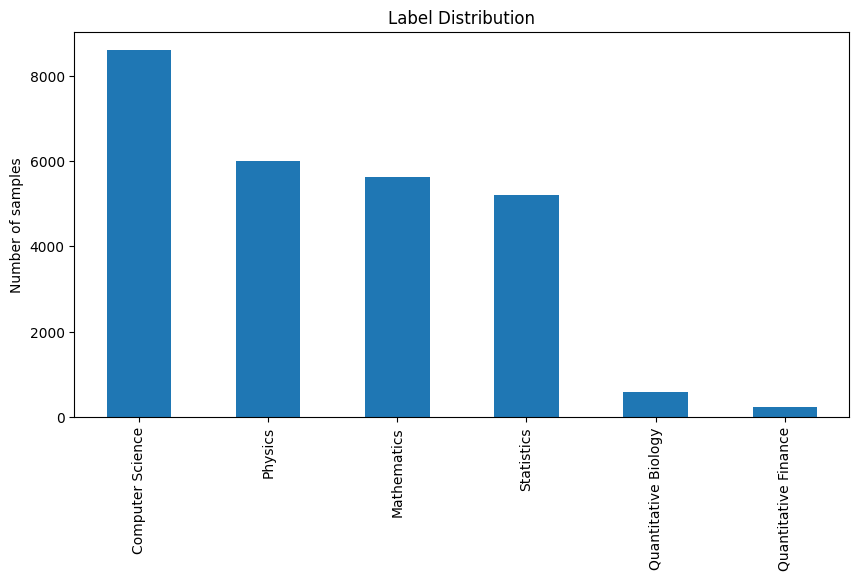

In [13]:
target_columns = ['Computer Science', 'Physics', 'Mathematics',
                  'Statistics', 'Quantitative Biology', 'Quantitative Finance']

label_counts = df_train[target_columns].sum().sort_values(ascending=False)

print("Label counts:")
print(label_counts)

import matplotlib.pyplot as plt

label_counts.plot(kind='bar', figsize=(10, 5), title='Label Distribution')
plt.ylabel('Number of samples')
plt.show()


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
import numpy as np

# 1. Define target columns
target_columns = ['Computer Science', 'Physics', 'Mathematics',
                  'Statistics', 'Quantitative Biology', 'Quantitative Finance']
y = df_train[target_columns]

# 2. Combine TITLE and ABSTRACT as features
X_text = df_train['TITLE'] + " " + df_train['ABSTRACT']

# 3. Vectorize the text
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X_text)

# 4. Optional Cross-Validation (before splitting)
base_clf = LogisticRegression(max_iter=1000, class_weight='balanced')
multi_clf = MultiOutputClassifier(base_clf)

# Use stratified KFold if labels were single-label; here use KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Running 5-fold cross-validation...")
cv_scores = cross_val_score(multi_clf, X, y, cv=cv, scoring='accuracy')
print("Cross-validation accuracies:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

# 5. Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

# 6. Train on training split
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

# 7. Predict
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# 8. Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print("\nTrain accuracy:", train_acc)
print("Validation accuracy:", val_acc)

# 9. Classification report
print("\nClassification report on validation set:\n")
print(classification_report(y_val, y_val_pred, target_names=target_columns))


Running 5-fold cross-validation...
Cross-validation accuracies: [0.63480334 0.62812872 0.64353839 0.62804006 0.63805436]
Mean accuracy: 0.634512974150597

Train accuracy: 0.7101388806103595
Validation accuracy: 0.634803337306317

Classification report on validation set:

                      precision    recall  f1-score   support

    Computer Science       0.81      0.88      0.84      1692
             Physics       0.85      0.88      0.87      1226
         Mathematics       0.78      0.86      0.81      1150
          Statistics       0.73      0.86      0.79      1069
Quantitative Biology       0.46      0.75      0.57       122
Quantitative Finance       0.67      0.82      0.74        45

           micro avg       0.78      0.87      0.82      5304
           macro avg       0.72      0.84      0.77      5304
        weighted avg       0.79      0.87      0.82      5304
         samples avg       0.82      0.89      0.83      5304



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
y_test_pred = clf.predict(X_test)

y_test_pred_df = pd.DataFrame(y_test_pred, columns=y_train.columns)
y_test_pred_df.head()


,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,0,0,1,1,0,0
1,0,1,0,0,0,0
2,1,0,0,0,0,0
3,0,1,0,0,0,0
4,1,0,1,0,0,0


In [14]:
import joblib
joblib.dump(clf, "multilabel_logreg_model.pkl")


['multilabel_logreg_model.pkl']

In [17]:
_test_pred_df = pd.DataFrame(y_test_pred, columns=y.columns)

y_test_pred_df.to_csv("test_predictions.csv", index=False)
print("\n✅ Predictions saved to 'test_predictions.csv'")


✅ Predictions saved to 'test_predictions.csv'
